# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'tensorflow': '2.10.0',
}
check_packages(d)

[OK] Your Python version is 3.8.10 (default, Mar 13 2023, 10:26:41) 
[GCC 9.4.0]


2023-07-19 21:58:17.878807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[OK] numpy 1.22.4
[OK] matplotlib 3.4.3
[OK] sklearn 1.0
[OK] tensorflow 2.10.0


### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)

In [3]:
from IPython.display import Image
%matplotlib inline

In [4]:
random_seed=42
num_epochs = 20
minibatch_size = 100
num_hidden = 500

## Obtaining and preparing the MNIST dataset

In [5]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [6]:
X = ((X / 255.) - .5) * 2

Split into training, validation, and test set:

In [7]:
from sklearn.model_selection import train_test_split


# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_seed, stratify=y)

# Further split the training set into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=random_seed, stratify=y_train)


# optional to free up some memory by deleting non-used arrays:
del X, y

In [8]:
import numpy as np

In [9]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))
    
def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

In [10]:
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

In [11]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

In [12]:
## Implementing a 1-layer Model (Vanial)

In [13]:
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=random_seed):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [14]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=num_hidden,
                     num_classes=10)

In [15]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [16]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [17]:
np.random.seed(random_seed) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=0.1)

Epoch: 001/020 | Train MSE: 0.03 | Train Acc: 86.15% | Valid Acc: 86.16%
Epoch: 002/020 | Train MSE: 0.02 | Train Acc: 88.90% | Valid Acc: 88.63%
Epoch: 003/020 | Train MSE: 0.02 | Train Acc: 89.91% | Valid Acc: 89.53%
Epoch: 004/020 | Train MSE: 0.02 | Train Acc: 90.66% | Valid Acc: 90.24%
Epoch: 005/020 | Train MSE: 0.02 | Train Acc: 91.10% | Valid Acc: 90.67%
Epoch: 006/020 | Train MSE: 0.02 | Train Acc: 91.57% | Valid Acc: 90.97%
Epoch: 007/020 | Train MSE: 0.02 | Train Acc: 91.96% | Valid Acc: 91.24%
Epoch: 008/020 | Train MSE: 0.02 | Train Acc: 92.20% | Valid Acc: 91.55%
Epoch: 009/020 | Train MSE: 0.01 | Train Acc: 92.52% | Valid Acc: 92.03%
Epoch: 010/020 | Train MSE: 0.01 | Train Acc: 92.72% | Valid Acc: 92.07%
Epoch: 011/020 | Train MSE: 0.01 | Train Acc: 92.99% | Valid Acc: 92.43%
Epoch: 012/020 | Train MSE: 0.01 | Train Acc: 93.25% | Valid Acc: 92.61%
Epoch: 013/020 | Train MSE: 0.01 | Train Acc: 93.54% | Valid Acc: 92.93%
Epoch: 014/020 | Train MSE: 0.01 | Train Acc: 93.66

## Implementing a 2-layer Model

In [18]:
##########################
### MODEL
##########################

class NeuralNetMLP2:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=random_seed):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # hidden 1
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # hidden 2
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer 1
        # input dim: [n_examples, n_features] dot [n_hidden1, n_features].T
        # output dim: [n_examples, n_hidden1]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        # input dim: [n_examples, n_hidden1] dot [n_hidden2, n_hidden1].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden2] dot [n_classes, n_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out)  # sigmoid derivative
        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out  # "delta (rule) placeholder"

        # gradient for output weights
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h2

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # Hidden layer 1 weights
        # [n_classes, n_hidden2]
        d_z_out__a_h2 = self.weight_out
        # output dim: [n_examples, n_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        # [n_examples, n_hidden2]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)  # sigmoid derivative
        # [n_examples, n_hidden1]
        d_z_h2__d_w_h2 = a_h1

        # output dim: [n_hidden2, n_hidden1]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h2__d_z_h2), axis=0)

        # Hidden layer 1 weights
        d_z_h2__a_h1 = self.weight_h2
        d_loss__a_h1 = np.dot(d_loss__a_h2 * d_a_h2__d_z_h2, d_z_h2__a_h1)
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
        d_z_h1__d_w_h1 = x
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)

In [19]:
model2 = NeuralNetMLP2(num_features=28*28,
                     num_hidden1=num_hidden,
                     num_hidden2=num_hidden,
                     num_classes=10)

## Coding the neural network training loop

Defining a function to compute the loss and accuracy

In [20]:
def compute_mse_and_acc2(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [21]:
def train2(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = model.backward(
                X_train_mini, a_h1, a_h2, a_out,
                y_train_mini)

            #### Update weights ####
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc2(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc2(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [22]:
np.random.seed(random_seed) # for the training set shuffling

epoch_loss2, epoch_train_acc2, epoch_valid_acc2 = train2(
    model2, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=0.1)

Epoch: 001/020 | Train MSE: 0.04 | Train Acc: 81.62% | Valid Acc: 81.89%
Epoch: 002/020 | Train MSE: 0.03 | Train Acc: 87.19% | Valid Acc: 87.05%
Epoch: 003/020 | Train MSE: 0.02 | Train Acc: 88.57% | Valid Acc: 88.53%
Epoch: 004/020 | Train MSE: 0.02 | Train Acc: 89.59% | Valid Acc: 89.43%
Epoch: 005/020 | Train MSE: 0.02 | Train Acc: 90.34% | Valid Acc: 90.11%
Epoch: 006/020 | Train MSE: 0.02 | Train Acc: 90.74% | Valid Acc: 90.40%
Epoch: 007/020 | Train MSE: 0.02 | Train Acc: 91.27% | Valid Acc: 90.82%
Epoch: 008/020 | Train MSE: 0.02 | Train Acc: 91.55% | Valid Acc: 90.95%
Epoch: 009/020 | Train MSE: 0.02 | Train Acc: 91.86% | Valid Acc: 91.38%
Epoch: 010/020 | Train MSE: 0.01 | Train Acc: 92.06% | Valid Acc: 91.54%
Epoch: 011/020 | Train MSE: 0.01 | Train Acc: 92.45% | Valid Acc: 91.85%
Epoch: 012/020 | Train MSE: 0.01 | Train Acc: 92.75% | Valid Acc: 92.20%
Epoch: 013/020 | Train MSE: 0.01 | Train Acc: 93.01% | Valid Acc: 92.32%
Epoch: 014/020 | Train MSE: 0.01 | Train Acc: 93.12

## Evaluating the neural network performance

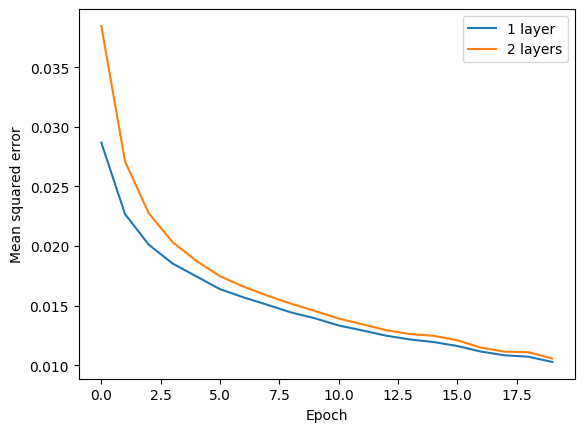

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(len(epoch_loss)), epoch_loss, label="1 layer")
plt.plot(range(len(epoch_loss2)), epoch_loss2, label="2 layers")
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

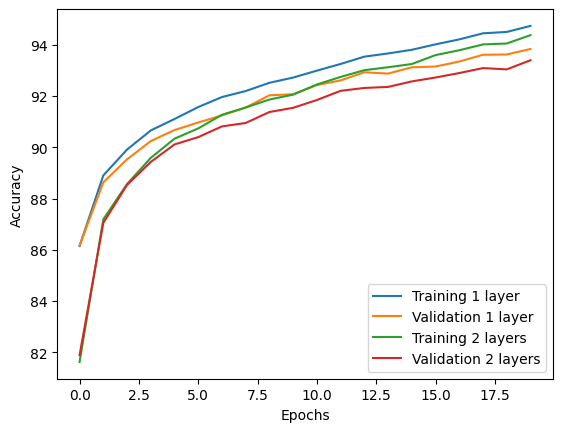

In [24]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training 1 layer')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation 1 layer')
plt.plot(range(len(epoch_train_acc2)), epoch_train_acc2,
         label='Training 2 layers')
plt.plot(range(len(epoch_valid_acc2)), epoch_valid_acc2,
         label='Validation 2 layers')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.show()

In [25]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'1 layer Test accuracy: {test_acc*100:.2f}%')

test_mse, test_acc = compute_mse_and_acc2(model2, X_test, y_test)
print(f'2 layers Test accuracy: {test_acc*100:.2f}%')

1 layer Test accuracy: 93.78%
2 layers Test accuracy: 93.39%


## Keras 2 layer model

In [26]:
from tensorflow import keras

num_classes = 10

y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train = keras.utils.to_categorical(y_train, num_classes)

In [27]:
import tensorflow as tf
model_keras = keras.Sequential([
    keras.layers.Dense(num_hidden, activation='sigmoid', input_shape=(28*28,)),
    keras.layers.Dense(num_hidden, activation='sigmoid'),
    keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = keras.optimizers.SGD(learning_rate=0.1)

# Compile the model
model_keras.compile(optimizer, loss='mse', metrics=['accuracy'])

# Train the model
model_keras.fit(X_train, y_train, minibatch_size, num_epochs, validation_data=(X_valid, y_valid))

model_keras.summary()

# Evaluate the model on the test set
test_loss, test_accuracy = model_keras.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/20


2023-07-19 22:01:50.416688: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 122931200 exceeds 10% of free system memory.


392/392 [==============================] - 3s 5ms/step - loss: 0.0901 - accuracy: 0.1574 - val_loss: 0.0892 - val_accuracy: 0.2357
Epoch 2/20
392/392 [==============================] - 2s 5ms/step - loss: 0.0888 - accuracy: 0.2742 - val_loss: 0.0884 - val_accuracy: 0.3510
Epoch 3/20
392/392 [==============================] - 2s 5ms/step - loss: 0.0879 - accuracy: 0.3403 - val_loss: 0.0874 - val_accuracy: 0.3381
Epoch 4/20
392/392 [==============================] - 2s 5ms/step - loss: 0.0868 - accuracy: 0.3555 - val_loss: 0.0862 - val_accuracy: 0.2774
Epoch 5/20
392/392 [==============================] - 2s 5ms/step - loss: 0.0854 - accuracy: 0.3609 - val_loss: 0.0846 - val_accuracy: 0.4217
Epoch 6/20
392/392 [==============================] - 2s 5ms/step - loss: 0.0836 - accuracy: 0.3851 - val_loss: 0.0824 - val_accuracy: 0.3906
Epoch 7/20
392/392 [==============================] - 2s 5ms/step - loss: 0.0812 - accuracy: 0.4070 - val_loss: 0.0797 - val_accuracy: 0.4066
Epoch 8/20
392/39

## Resoult comparison original 1 layer, my 2 layers and outof the box keras 2 layers 

In [28]:
# Calculate AUC on the test set
from sklearn.metrics import roc_auc_score

_, _, probas2 = model2.forward(X_test)
auc_score_2 = roc_auc_score(y_test, probas2, average='macro', multi_class='ovr')

_, probas1 = model.forward(X_test)
auc_score_1 = roc_auc_score(y_test, probas1, average='macro', multi_class='ovr')

y_pred_test = model_keras.predict(X_test)
auc_score_keras = roc_auc_score(y_test, y_pred_test, average='macro', multi_class='ovr')

print(f'Vanila (1 layer) AUC score: {auc_score_1:.4f}')
print(f'2 layer AUC score: {auc_score_2:.4f}')
print(f'Keras 2 layers AUC score: {auc_score_keras:.4f}')

657/657 [==============================] - 1s 1ms/step
Vanila (1 layer) AUC score: 0.9920
2 layer AUC score: 0.9916
Keras 2 layers AUC score: 0.9790
